# Business Problem

Here we will try to fit in Time Series Forecasting methods to predict future sales of the products of in the data set

# Loading the Packages

In [102]:
library(lubridate)
library(ggplot2)
library(tidyverse)
# Library to forecast
library(forecast)
# Library Simple Moving Average
library(TTR)
# Library MAPE
library(MLmetrics)
# Library for Processing date data type
library(zoo)
library(xts)
library(TSstudio)
library(tseries)

# Loading Data 

In [103]:
train <- read.csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test <- read.csv('../input/competitive-data-science-predict-future-sales/test.csv')

head(train)
head(test)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,02.01.2013,0,59,22154,999.00,1
2,03.01.2013,0,25,2552,899.00,1
3,05.01.2013,0,25,2552,899.00,-1
4,06.01.2013,0,25,2554,1709.05,1
5,15.01.2013,0,25,2555,1099.00,1
6,10.01.2013,0,25,2564,349.00,1


,ID,shop_id,item_id
,<int>,<int>,<int>
1,0,5,5037
2,1,5,5320
3,2,5,5233
4,3,5,5232
5,4,5,5268
6,5,5,5039


**Exploring the other datasets given.Since I will directly fit in Time Series Forecasting methods without any EDA companent,I will not data wrangle the data below**

In [3]:
categories <- read.csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items <- read.csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops <- read.csv('../input/competitive-data-science-predict-future-sales/shops.csv')

head(categories)
head(items)
head(shops)

,item_category_name,item_category_id
,<chr>,<int>
1,PC - Гарнитуры/Наушники,0
2,Аксессуары - PS2,1
3,Аксессуары - PS3,2
4,Аксессуары - PS4,3
5,Аксессуары - PSP,4
6,Аксессуары - PSVita,5


,item_name,item_id,item_category_id
,<chr>,<int>,<int>
1,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
2,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
3,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
5,***КОРОБКА (СТЕКЛО) D,4,40
6,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) D,5,40


,shop_name,shop_id
,<chr>,<int>
1,"!Якутск Орджоникидзе, 56 фран",0
2,"!Якутск ТЦ ""Центральный"" фран",1
3,"Адыгея ТЦ ""Мега""",2
4,"Балашиха ТРК ""Октябрь-Киномир""",3
5,"Волжский ТЦ ""Волга Молл""",4
6,"Вологда ТРЦ ""Мармелад""",5


In [104]:
summary(train)

     date           date_block_num     shop_id      item_id     
 Length:2935849     Min.   : 0.00   Min.   : 0   Min.   :    0  
 Class :character   1st Qu.: 7.00   1st Qu.:22   1st Qu.: 4476  
 Mode  :character   Median :14.00   Median :31   Median : 9343  
                    Mean   :14.57   Mean   :33   Mean   :10197  
                    3rd Qu.:23.00   3rd Qu.:47   3rd Qu.:15684  
                    Max.   :33.00   Max.   :59   Max.   :22169  
   item_price        item_cnt_day     
 Min.   :    -1.0   Min.   : -22.000  
 1st Qu.:   249.0   1st Qu.:   1.000  
 Median :   399.0   Median :   1.000  
 Mean   :   890.9   Mean   :   1.243  
 3rd Qu.:   999.0   3rd Qu.:   1.000  
 Max.   :307980.0   Max.   :2169.000  

**We change the date from character to date format for easier time series analysis**

In [105]:
train$date <- dmy(train$date)

head(train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<date>,<int>,<int>,<int>,<dbl>,<dbl>
1,2013-01-02,0,59,22154,999.00,1
2,2013-01-03,0,25,2552,899.00,1
3,2013-01-05,0,25,2552,899.00,-1
4,2013-01-06,0,25,2554,1709.05,1
5,2013-01-15,0,25,2555,1099.00,1
6,2013-01-10,0,25,2564,349.00,1


In [106]:
sales_forecasting <- train %>% select(c(date,item_price))

sales_forecasting$date <- ymd(sales_forecasting$date)

head(sales_forecasting)

,date,item_price
,<date>,<dbl>
1,2013-01-02,999.00
2,2013-01-03,899.00
3,2013-01-05,899.00
4,2013-01-06,1709.05
5,2013-01-15,1099.00
6,2013-01-10,349.00


**We see that start data is 1st January 2013 and end date in the data set is October 2015**

In [107]:
summary(sales_forecasting)

      date              item_price      
 Min.   :2013-01-01   Min.   :    -1.0  
 1st Qu.:2013-08-01   1st Qu.:   249.0  
 Median :2014-03-04   Median :   399.0  
 Mean   :2014-04-03   Mean   :   890.9  
 3rd Qu.:2014-12-05   3rd Qu.:   999.0  
 Max.   :2015-10-31   Max.   :307980.0  

**We aggregate sales of the products for the month since it will be easier to fit in time series models **

In [109]:
data_new1 <- sales_forecasting                                  # Duplicate data
data_new1$year <- strftime(data_new1$date, "%Y")    # Create year column
data_new1$month <- strftime(data_new1$date, "%m")   # Create month column
head(data_new1)                                     # Head of updated data
 

,date,item_price,year,month
,<date>,<dbl>,<chr>,<chr>
1,2013-01-02,999.00,2013,01
2,2013-01-03,899.00,2013,01
3,2013-01-05,899.00,2013,01
4,2013-01-06,1709.05,2013,01
5,2013-01-15,1099.00,2013,01
6,2013-01-10,349.00,2013,01


In [116]:
data_aggr1 <- aggregate(item_price ~ month + year,data_new1,FUN = sum)
head(data_aggr1)                                 
  

,month,year,item_price
,<chr>,<chr>,<dbl>
1,01,2013,82211874
2,02,2013,75580187
3,03,2013,84298312
4,04,2013,61512823
5,05,2013,57274132
6,06,2013,63343615


**Since the numbers for sales are large , we will convert to millions of dollars by dividing the number with corresponding zeros to the prices**

In [117]:
data_aggr1$item_price <- round(data_aggr1$item_price/1000000)

head(data_aggr1)
tail(data_aggr1)

,month,year,item_price
,<chr>,<chr>,<dbl>
1,01,2013,82
2,02,2013,76
3,03,2013,84
4,04,2013,62
5,05,2013,57
6,06,2013,63


,month,year,item_price
,<chr>,<chr>,<dbl>
29,05,2015,59
30,06,2015,56
31,07,2015,54
32,08,2015,54
33,09,2015,59
34,10,2015,66


In [118]:
colnames(data_aggr1) <- c('month','year','sales')

**Transforming the data into time series**

In [119]:
forecasting <- data_aggr1 %>% select(sales)

df <- ts(forecasting,frequency=12,start=c(2013,1),end=c(2015,10))

head(df)

,Jan,Feb,Mar,Apr,May,Jun
2013,82,76,84,62,57,63


**Total Sales viz**

In [ ]:
autoplot(df)+geom_smooth(method='loess') + ggtitle('Sales of Products Yearly')+xlab('Year') +ylab('$ Millions')

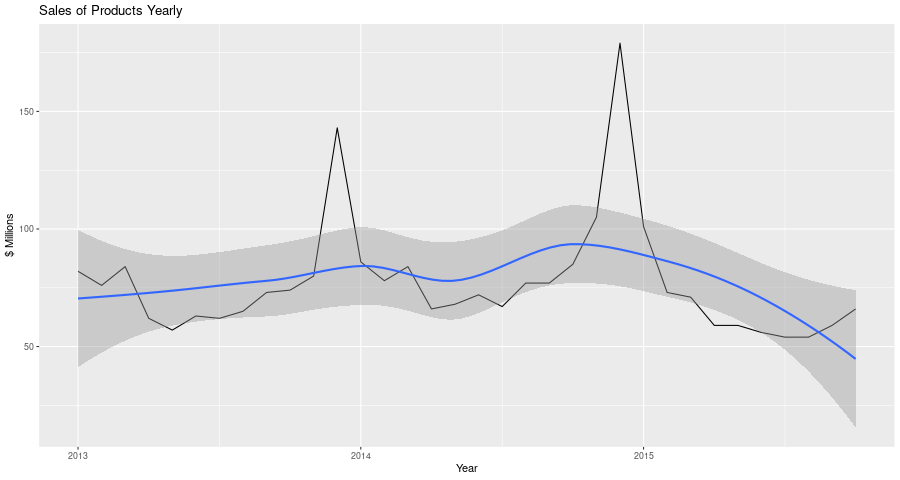

**We see a trend of decreasing sales from the year 2014 and the trend line seems to be going down**

**Observing seasonal sales**

In [ ]:
ggseasonplot(df, year.labels=TRUE, year.labels.left=TRUE) +
  ylab("$ million") +
  ggtitle("Seasonal plot: Product Sales")

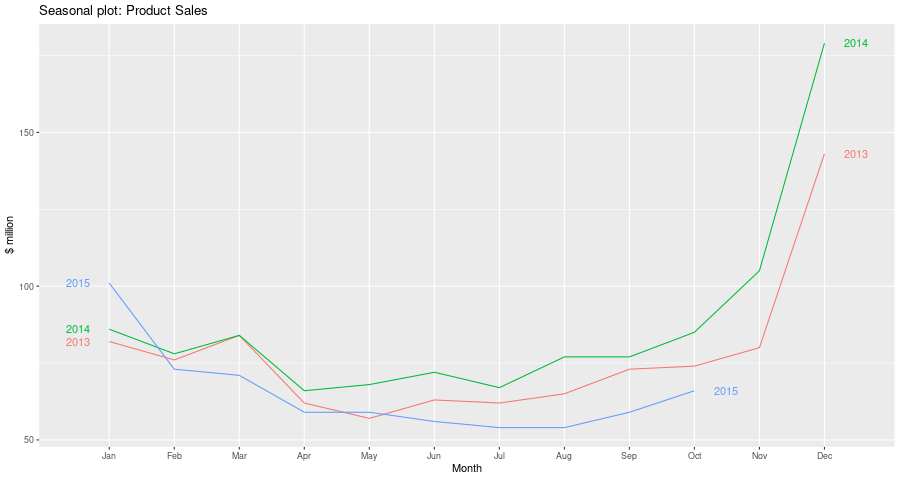

**Clearly large sales are done during winter months of Nov,Dec.It can be assumed that Decemeber 2015 will have much larger sales compared to the previous months**

In [ ]:
ggseasonplot(df, polar=TRUE) +
  ylab("$ million") +
  ggtitle("Seasonal plot: Sale of Products")

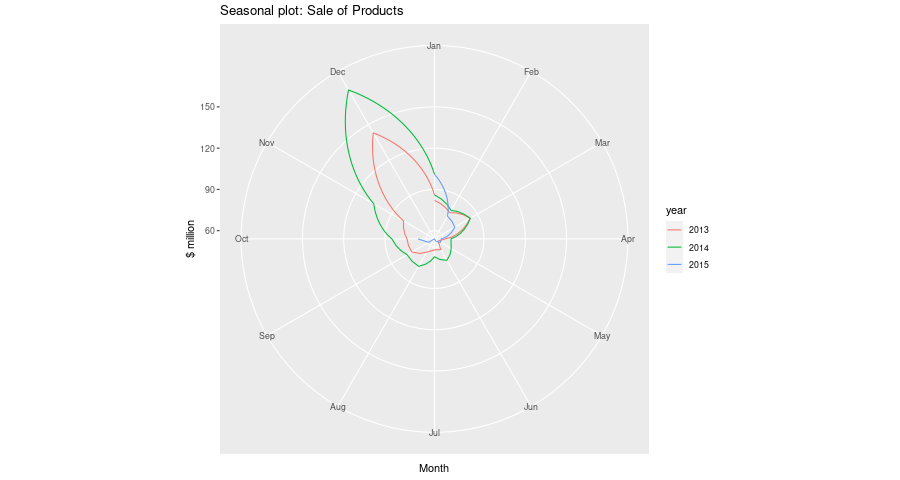

**Decomposing the time series.**

**Since we see that troughs and ranges of the sales graph are not increasing/decreasing over month/yearly, we can say that the data is Additive model** 

In [ ]:
df_sales <- decompose(df)

plot(df_sales)

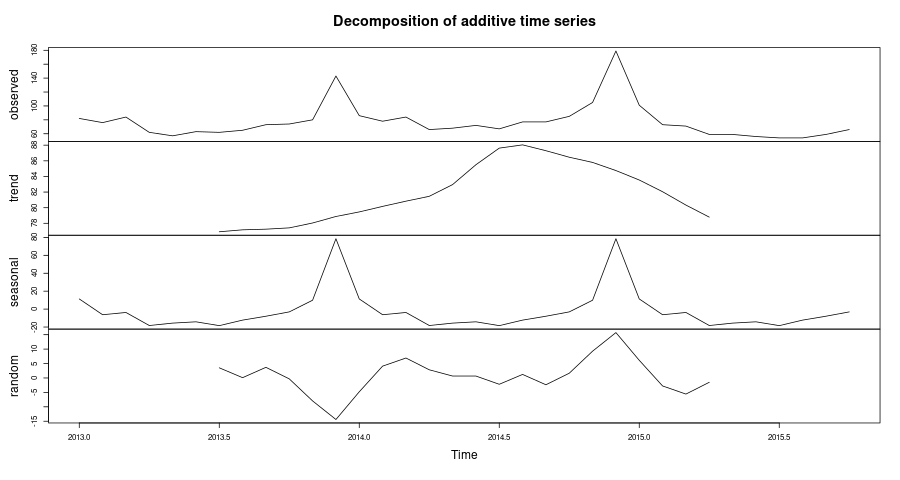

**Testing whether the ts is stationary or not**

**Augmented Dickey-Fuller Test (adf test). A p-Value of less than 0.05 in adf.test() indicates that it is stationary.**

In [124]:
adf.test(df)


	Augmented Dickey-Fuller Test

data:  df
Dickey-Fuller = -2.599, Lag order = 3, p-value = 0.3409
alternative hypothesis: stationary


**P - Value shows that the data is not stationary**

**Checking the total number of months in the data before perform Cross Validation**

In [125]:
nrow(df)

[1] 34

# Cross Validatation

**Since we have few number of months in total, we will remove 12 rows of data for testing the model**

In [126]:
df_train <- head(df, length(df) - 12)
df_test <- tail(df, 12)

In [76]:
head(df_test)

[[1]]
[1] 105344816

[[2]]
[1] 179405712

[[3]]
[1] 100573604

[[4]]
[1] 72559497

[[5]]
[1] 71458419

[[6]]
[1] 58971926

Transforming the test and training set into time series

In [127]:
df_train_ts <- ts(df_train, start=c(2013, 1), end=c(2015, 10), frequency=12)

df_test_ts <- ts(df_test,start=c(2013, 1), end=c(2016, 10), frequency=12)

# Model Fitting

**We will fit the data to different Time Series algorthims for evaluation and which works the best**

# Naive-Method

**The simplest forecasting method is to use the most recent observation as the forecast for the next observation. This is called a naive forecast and can be implemented using the 'naive()' function. This method may not be the best forecasting technique, but it often provides a useful benchmark for other, more advanced forecasting methods.**

In [128]:
naive_mod <- naive(df_train_ts, h = 12)
summary(naive_mod)


Forecast method: Naive method

Model Information:
Call: naive(y = df_train_ts, h = 12) 

Residual sd: 20.1065 

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.848485 20.10653 11.48485 -0.2836224 13.19858 0.9643766
                   ACF1
Training set -0.2177017

Forecasts:
         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Nov 2015            143 117.23244 168.7676 103.591917 182.4081
Dec 2015            143 106.55917 179.4408  87.268554 198.7314
Jan 2016            143  98.36928 187.6307  74.743197 211.2568
Feb 2016            143  91.46488 194.5351  64.183833 221.8162
Mar 2016            143  85.38198 200.6180  54.880847 231.1192
Apr 2016            143  79.88262 206.1174  46.470304 239.5297
May 2016            143  74.82544 211.1746  38.736012 247.2640
Jun 2016            143  70.11833 215.8817  31.537108 254.4629
Jul 2016            143  65.69732 220.3027  24.775750 261.2243
Aug 2016            143  61.51582 224.484

In [129]:
df_test$naive <- 143

df_test$naive<- as.integer(df_test$naive)

Warning message in df_test$naive <- 143:
“Coercing LHS to a list”


In [130]:
res_naive <- MAPE(y_pred = df_test$naive, y_true = df_test_ts)*100

res_naive

[1] 109.4954

In [ ]:
plot(df,  main="Forecast for Yearly/Monthly Sales", xlab="Time", ylab="Millions of Dollars")

lines(naive_mod$mean, col=4)

legend("topright", lty=1, col=c(4,2), 
       legend=c("Naive method"))

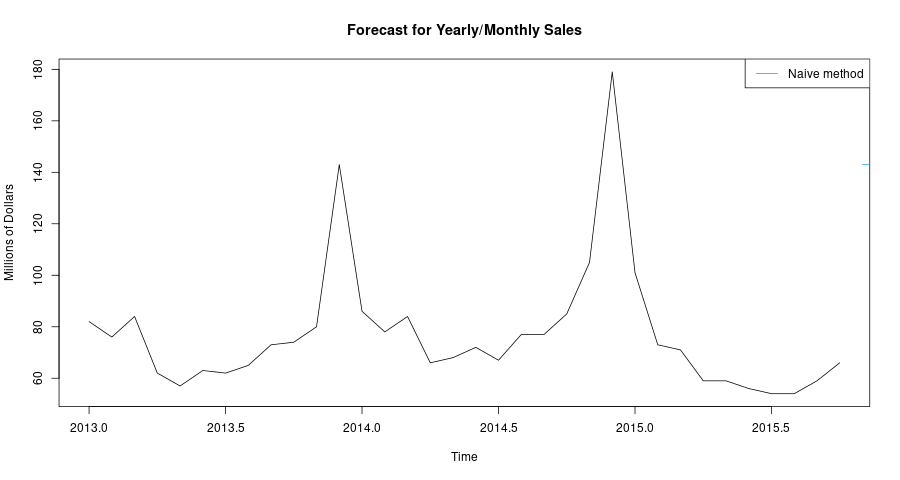

# Simple Exponential Smoothing

**Exponential Smoothing methods are an extension of the naive method, wherein the forecasts are produced using weighted averages of past observations, with the weights decaying exponentially as the observations get older. In simple words, higher weights are given to the more recent observations and vice versa. The value of the smoothing parameter for the level is decided by the parameter 'alpha'.**

In [134]:
se_model <- ses(df_train_ts, h = 12)
summary(se_model)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = df_train_ts, h = 12) 

  Smoothing parameters:
    alpha = 0.6229 

  Initial states:
    l = 79.6481 

  sigma:  19.5663

     AIC     AICc      BIC 
326.0541 326.8541 330.6331 

Error measures:
                   ME     RMSE     MAE       MPE    MAPE      MASE        ACF1
Training set 1.818106 18.98211 11.1158 -0.680583 12.8706 0.9333879 0.003839038

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Nov 2015       118.1561 93.08089 143.2314 79.80686 156.5054
Dec 2015       118.1561 88.61343 147.6988 72.97447 163.3378
Jan 2016       118.1561 84.73795 151.5743 67.04744 169.2648
Feb 2016       118.1561 81.26741 155.0448 61.73970 174.5726
Mar 2016       118.1561 78.09641 158.2158 56.89007 179.4222
Apr 2016       118.1561 75.15863 161.1536 52.39713 183.9151
May 2016       118.1561 72.40913 163.9031 48.19213 188.1201
Jun 2016       118.1561 69.81576 166.4965

In [135]:
df_test$se <- 118.1

df_test$se <- as.integer(df_test$se)

In [136]:
res_se <- MAPE(y_pred = df_test$se, y_true = df_test_ts)*100

res_se

[1] 75.91079

In [ ]:
autoplot(se_model) +
  autolayer(fitted(se_model), series="Fitted") +
  ylab("Sales (millions of Dollars)") + xlab("Year")

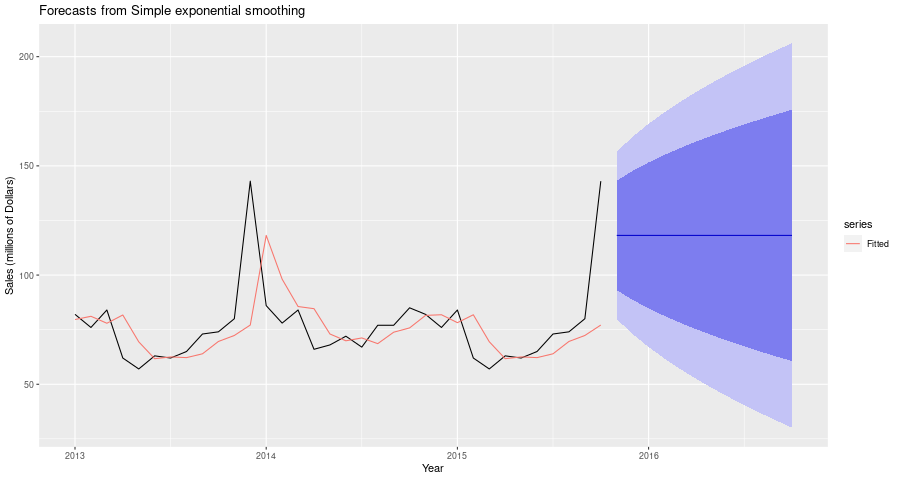

# Holt's Trend Method 

**This is an extension of the simple exponential smoothing method which considers the trend component while generating forecasts. This method involves two smoothing equations, one for the level and one for the trend component.**

In [139]:
holt_model <- holt(df,h=12)

holt_model

         Point Forecast       Lo 80     Hi 80      Lo 95    Hi 95
Nov 2015       61.90046  29.0207991  94.78012  11.615359 112.1856
Dec 2015       61.44867  22.8820342 100.01531   2.466089 120.4313
Jan 2016       60.99689  17.4787092 104.51506  -5.558422 127.5522
Feb 2016       60.54510  12.5825055 108.50769 -12.807358 133.8976
Mar 2016       60.09331   8.0633049 112.12332 -19.479718 139.6663
Apr 2016       59.64153   3.8386083 115.44445 -25.701673 144.9847
May 2016       59.18974  -0.1477884 118.52727 -31.559179 149.9387
Jun 2016       58.73795  -3.9362162 121.41213 -37.113918 154.5898
Jul 2016       58.28617  -7.5567789 124.12912 -42.411930 158.9843
Aug 2016       57.83438 -11.0326523 126.70142 -47.488658 163.1574
Sep 2016       57.38260 -14.3821301 129.14732 -52.372081 167.1373
Oct 2016       56.93081 -17.6199525 131.48157 -57.084742 170.9464

In [140]:
holt_model$mean

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2015,,,,,,,,,,,61.90046,61.44867
2016,60.99689,60.54510,60.09331,59.64153,59.18974,58.73795,58.28617,57.83438,57.38260,56.93081,,


In [141]:
df_holt <- as.data.frame(holt_model)

df_test$holt <- df_holt$`Point Forecast`

In [142]:
res_holt <- MAPE(y_pred = df_test$holt, y_true = df_test_ts)*100

res_holt

Warning message in `-.default`(y_true, y_pred):
“longer object length is not a multiple of shorter object length”


[1] 18.47361

**The forecasts generated by Holt’s linear method display a constant trend (increasing or decreasing) indefinitely into the future. Empirical evidence indicates that these methods tend to over-forecast, especially for longer forecast horizons. Motivated by this observation, Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some time in the future. Methods that include a damped trend have proven to be very successful, and are arguably the most popular individual methods when forecasts are required automatically for many series.**

In [143]:
holt_model_damp <- holt(df,damped = TRUE ,phi = 0.9,h=15)

holt_model_damp

         Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
Nov 2015       62.65319  29.204362  96.10202  11.497622 113.8088
Dec 2015       62.63891  23.325657 101.95216   2.514478 122.7633
Jan 2016       62.62606  18.214893 107.03723  -5.294958 130.5471
Feb 2016       62.61449  13.632127 111.59686 -12.297572 137.5266
Mar 2016       62.60408   9.441282 115.76688 -18.701405 143.9096
Apr 2016       62.59471   5.556339 119.63309 -24.637953 149.8274
May 2016       62.58628   1.918807 123.25376 -30.196614 155.3692
Jun 2016       62.57869  -1.513232 126.67062 -35.441449 160.5988
Jul 2016       62.57186  -4.771042 129.91477 -40.420223 165.5640
Aug 2016       62.56572  -7.878676 133.01011 -45.169686 170.3011
Sep 2016       62.56019 -10.855115 135.97549 -49.718828 174.8392
Oct 2016       62.55521 -13.715650 138.82606 -54.091003 179.2014
Nov 2016       62.55073 -16.472814 141.57427 -58.305350 183.4068
Dec 2016       62.54669 -19.137035 144.23042 -62.377788 187.4712
Jan 2017       62.54306 -

In [ ]:
autoplot(df) +
  autolayer(holt_model, series="Holt's method", PI=FALSE) +
  autolayer(holt_model_damp, series="Damped Holt's method", PI=FALSE) +
  ggtitle("Forecasts from Holt's method") + xlab("Year") +
  ylab("Sales in Millions)") +
  guides(colour=guide_legend(title="Forecast"))

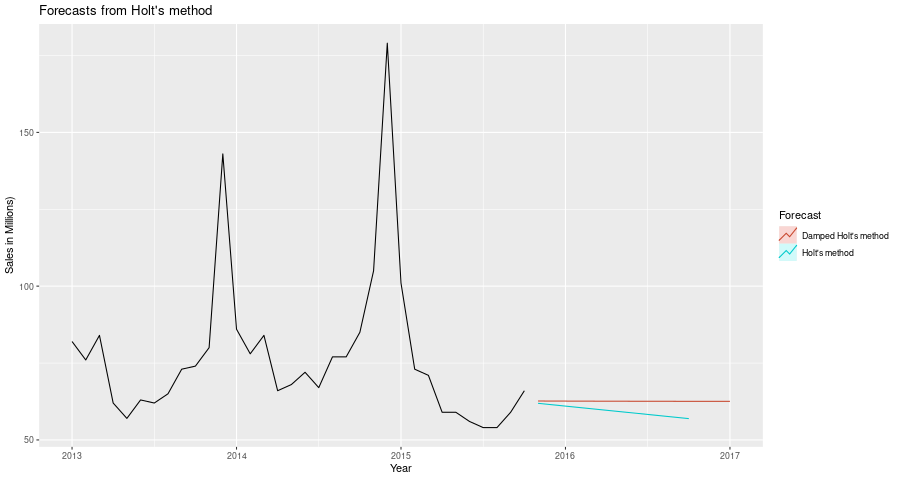

In [149]:
library(DT)

Model <- c('Naive','Simple Exponential Smoothing','Holt Trend Method')

MAPE <- c(res_naive,res_se,res_holt)

df <- data.frame(Model, MAPE)

datatable(df)

HTML widgets cannot be represented in plain text (need html)

**We see that Holt's Trend seems to best forecast among the above methods to predict future sales**